In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
import pandas as pd
import numpy as np

In [7]:
bs = 16

In [8]:
df = pd.read_csv('characters_data.csv')
df.head()

,filename,character,origin,game,gender,publisher
0,data/nintendo/peach.clean/000208.jpg,peach,NaN,NaN,NaN,nintendo
1,data/nintendo/peach.clean/000252.jpg,peach,NaN,NaN,NaN,nintendo
2,data/nintendo/peach.clean/000517.jpg,peach,NaN,NaN,NaN,nintendo
3,data/nintendo/peach.clean/000221.jpg,peach,NaN,NaN,NaN,nintendo
4,data/nintendo/peach.clean/000202.jpg,peach,NaN,NaN,NaN,nintendo


In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4535 entries, 0 to 4534
Data columns (total 6 columns):
filename     4535 non-null object
character    4535 non-null object
origin       0 non-null float64
game         0 non-null float64
gender       0 non-null float64
publisher    4535 non-null object
dtypes: float64(3), object(3)
memory usage: 212.7+ KB
None


In [10]:
# don't have a dedicated train/test set so have to create that here
seed = 42
np.random.seed(seed)

In [11]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.ix[perm[:train_end]]
    validate = df.ix[perm[train_end:validate_end]]
    test = df.ix[perm[validate_end:]]
    return train, validate, test

In [12]:
# create training and test sets. Validate is 0 here since it will be made automatically below
train, validate, test = train_validate_test_split(df, validate_percent=0, seed=seed)

/home/toruitas/anaconda3/envs/painter/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys
/home/toruitas/anaconda3/envs/painter/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/home/toruitas/anaconda3/envs/painter/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


In [13]:
train_path = Path(".")

In [14]:
tfms = get_transforms(do_flip=True)

In [15]:
data = ImageDataBunch.from_df(train_path, train, ds_tfms=tfms, size=299, bs=bs//2)

In [35]:
data

ImageDataBunch;

Train: LabelList (2177 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
baby_mario,luigi,peach,baby_luigi,mario
Path: .;

Valid: LabelList (544 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
bowser,mario,luigi,luigi,peach
Path: .;

Test: None

In [36]:
data.classes

['baby_luigi',
 'baby_mario',
 'bowser',
 'daisy',
 'luigi',
 'mario',
 'peach',
 'toad']

In [37]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


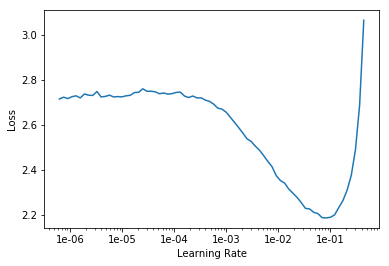

In [38]:
learn.lr_find()
learn.recorder.plot()

In [39]:
learn.fit_one_cycle(7)

epoch,train_loss,valid_loss,accuracy,time
0,1.935121,1.193965,0.579044,00:32
1,1.361362,0.993266,0.667279,00:27
2,1.091776,0.930287,0.676471,00:28
3,0.892936,0.869262,0.707721,00:28
4,0.757707,0.833106,0.709559,00:33
5,0.657332,0.821034,0.722426,00:40
6,0.596940,0.807658,0.720588,00:43


In [40]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

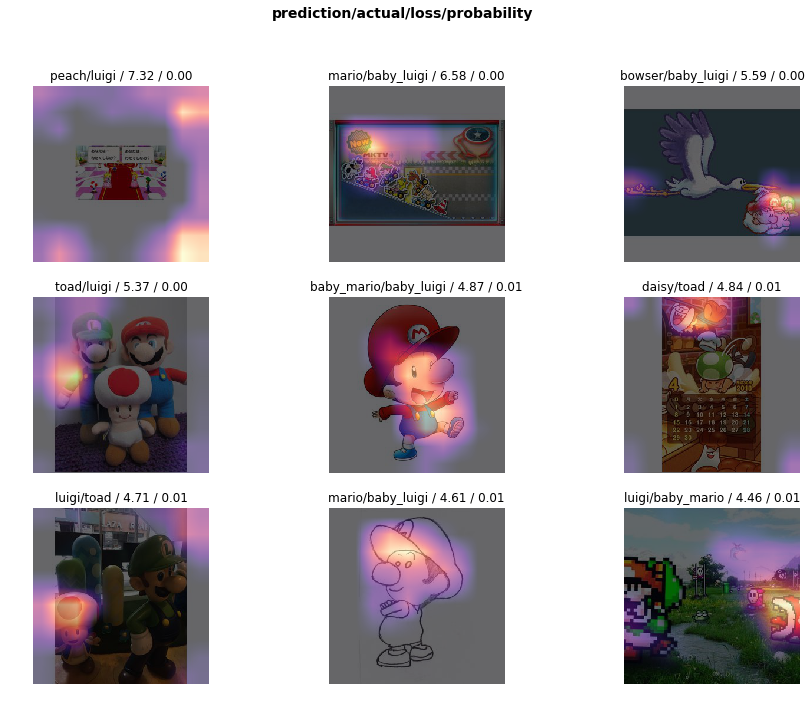

In [41]:
interp.plot_top_losses(9, figsize=(15,11))

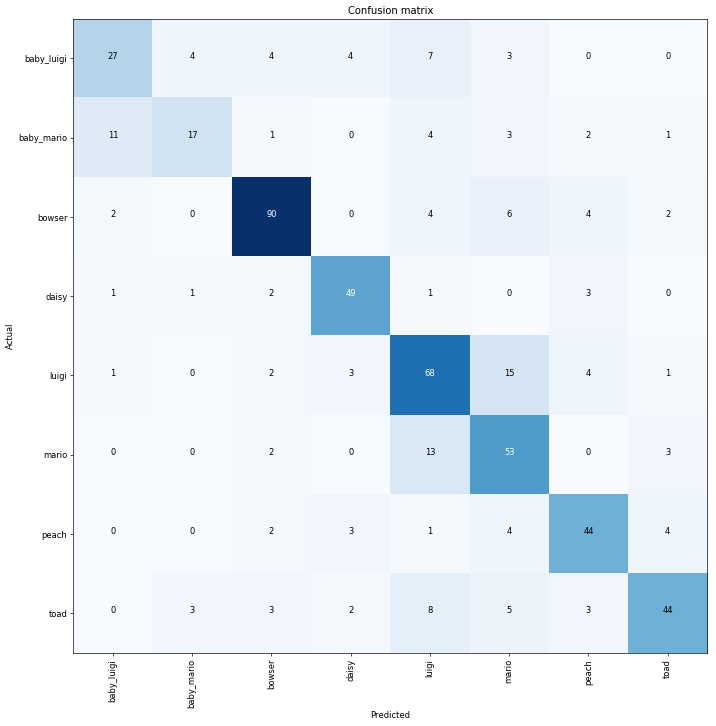

In [43]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [44]:
interp.most_confused(min_val=2)

[('luigi', 'mario', 15),
 ('mario', 'luigi', 13),
 ('baby_mario', 'baby_luigi', 11),
 ('toad', 'luigi', 8),
 ('baby_luigi', 'luigi', 7),
 ('bowser', 'mario', 6),
 ('toad', 'mario', 5),
 ('baby_luigi', 'baby_mario', 4),
 ('baby_luigi', 'bowser', 4),
 ('baby_luigi', 'daisy', 4),
 ('baby_mario', 'luigi', 4),
 ('bowser', 'luigi', 4),
 ('bowser', 'peach', 4),
 ('luigi', 'peach', 4),
 ('peach', 'mario', 4),
 ('peach', 'toad', 4),
 ('baby_luigi', 'mario', 3),
 ('baby_mario', 'mario', 3),
 ('daisy', 'peach', 3),
 ('luigi', 'daisy', 3),
 ('mario', 'toad', 3),
 ('peach', 'daisy', 3),
 ('toad', 'baby_mario', 3),
 ('toad', 'bowser', 3),
 ('toad', 'peach', 3),
 ('baby_mario', 'peach', 2),
 ('bowser', 'baby_luigi', 2),
 ('bowser', 'toad', 2),
 ('daisy', 'bowser', 2),
 ('luigi', 'bowser', 2),
 ('mario', 'bowser', 2),
 ('peach', 'bowser', 2),
 ('toad', 'daisy', 2)]

In [45]:
learn.unfreeze()

In [46]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.991688,0.851279,0.718750,00:37


In [48]:
learn.unfreeze()
learn.fit_one_cycle(7, max_lr=slice(1e-3,1e-1))

epoch,train_loss,valid_loss,accuracy,time
0,2.431216,2162.962158,0.279412,00:39
1,3.235852,8124.887695,0.104779,00:51
2,5.081786,17.002625,0.099265,00:56
3,4.712498,43738.816406,0.137868,01:03
4,3.620219,138.845001,0.126838,01:04
5,2.761905,11923.625000,0.159926,01:05
6,2.358007,24471.029297,0.216912,01:06


In [16]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


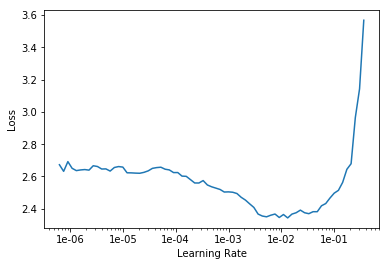

In [17]:
learn.lr_find()
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(7, max_lr=slice(1e-3,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,1.403231,1.201395,0.612132,00:50
1,1.437544,1.185750,0.604779,00:53
2,1.308551,1.108113,0.658088,01:11
3,1.039034,0.929254,0.704044,01:28
4,0.904369,0.798069,0.727941,01:30
5,0.825686,0.902527,0.735294,01:38
6,0.744416,0.850892,0.750000,01:39


In [19]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

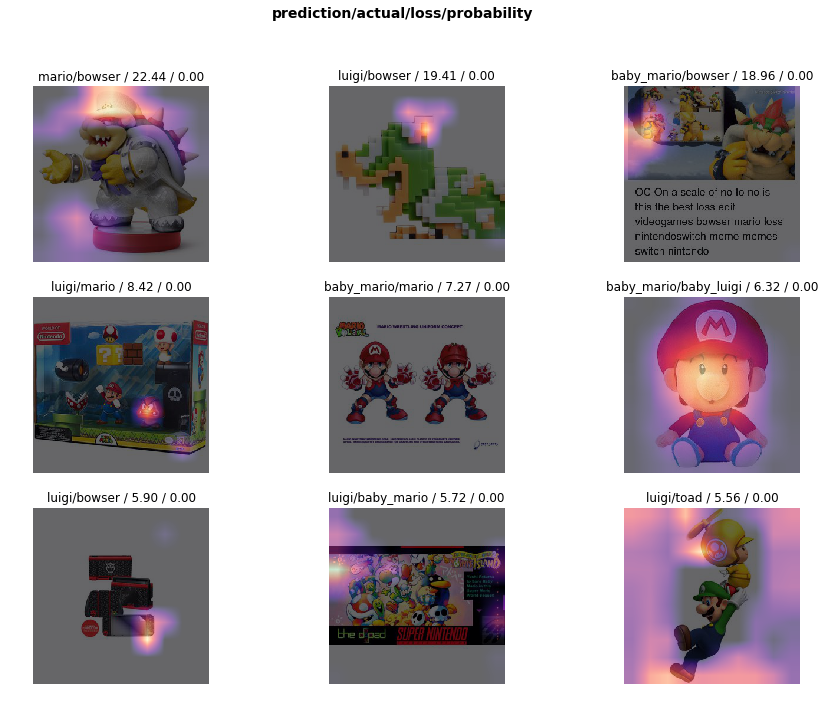

In [20]:
interp.plot_top_losses(9, figsize=(15,11))

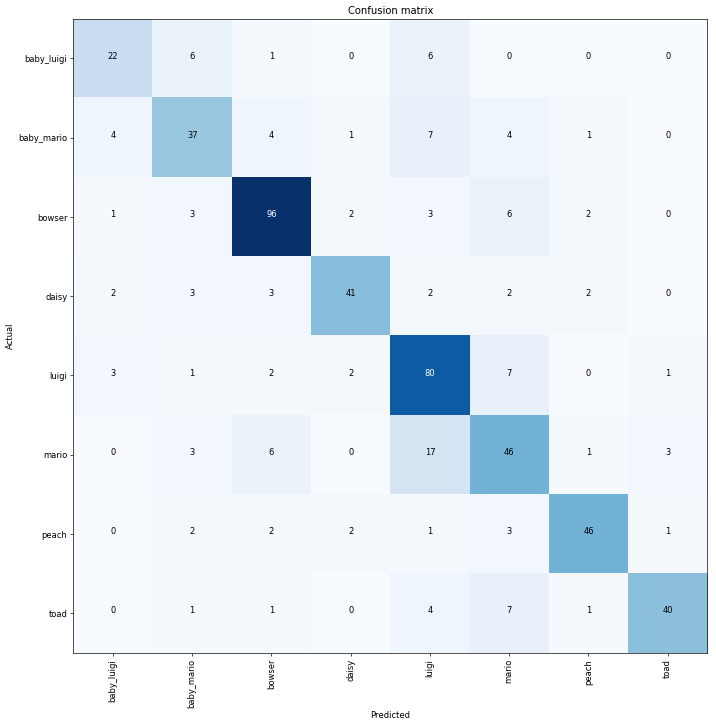

In [21]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)